<a href="https://colab.research.google.com/github/vladtsyp/study_deeplearning/blob/main/task_5/task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическая работа №5. Архитектуры НС и Transfer Learning.

In [1]:
# импорт зависимостей
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

from google.colab import drive
drive.mount('/content/drive')
from imutils import paths
import random
import pickle
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

Mounted at /content/drive


# Задание 1. Использование предобученной модели

## 1.1. Выберите и импортируйте предобученную модель СНС для решения задач классификации из имеющихся в Keras: https://keras.io/api/applications/

In [2]:
model = keras.applications.Xception()
# model.summary() Вывод краткого описания архитектуры созданной модели
# model.get_config() # Вывод конфигурации созданной модели

91884032/91884032 [==============================] - 1s 0us/step


## 1.2. Загрузите из сети Интернет 5 изображений с разными классами, из тех, что приведены в [списке](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), и сохраните их представление в список images

In [43]:
# orange, apple, banana
images = ['https://www.quanta.org/thumbs/thumb-orange-640x480-orange.jpg',
          'https://thewellnessworkshop.org/wp-content/uploads/2017/11/Depositphotos_38451321_original-1024x683.jpg',
          'https://i.pinimg.com/originals/71/ad/d0/71add085dedf7edd9b83430e3fe57638.jpg',
          'https://img.freepik.com/premium-photo/one-banana-isolated-on-white-background-top-view-flat-lay_438009-4982.jpg',
          'https://catherineasquithgallery.com/uploads/posts/2021-03/1614572706_61-p-banan-na-belom-fone-71.jpg']

## 1.3. Напишите функцию, принимающую на вход список с исходными изображениями и возвращающую список с преобразованными изображениями под формат входных данных выбранной Вами модели СНС.

(Не забудьте создать независимую копию исходного списка в теле функции, для обработки именно независимой копии, а не оригинального списка)

In [44]:
# list copy, ибо списки в питоне - ссылочные // a = list(b) или a = b.copy()

def imagePre(imageList, for_model_inp=True, from_gdrive=False, shapes=[64, 64, 3]):
  images = list()

  for x in imageList:

    if (from_gdrive == False):
      req = urlopen(x) # используя метод urlopen, получаем объект запроса по ссылке (изображение)
                      # и сохраняем его в виде потокового набора данных в переменную "req"
      image_1 = np.asarray(bytearray(req.read()), dtype=np.uint8) # преобразуем потоковый набор данных в массив numpy
      image_1 = cv2.imdecode(image_1, -1) # декодируем изображение в привычный для отображения формат
    else:
      image_1 = cv2.imread(x)

    #image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
      # для конвертации BGR в RGB, т.к. Xception обучалась на RGB формате
      # а cv2.imread читает в BGR
    image_1 = image_1[:,:,::-1]
    image_1 = cv2.resize(image_1, (shapes[0], shapes[1]))

    if (for_model_inp == True):
      image_1 = image_1.reshape(-1, shapes[0], shapes[1], shapes[2])
      image_1 = keras.applications.xception.preprocess_input(image_1)
      
    images.append(image_1)
  
  return images

## 1.4. Напишите функцию, принимающую на вход список с представлениями обработанных изображений (результат работы функции из п. 1.3.) и возвращающую список предсказанных нейросетью классов. 

In [54]:
def getListPred(images, model, decode=False, decode_top=3, fnm=False):
  listPred = list()

  for image in images:
    result = model.predict(image)
    maxArg = np.argmax(result)
    if (decode == True):
      decode_pred = keras.applications.xception.decode_predictions(result, top=decode_top)
      listPred.append([maxArg, decode_pred])
    else:
      if (fnm == False):
        listPred.append(maxArg)
      else:
        listPred.append([result, maxArg])
  return listPred

## 1.5. Выведите изображения и соответствующие им классы, вызывая соответствующие функции

In [46]:
images_fi = imagePre(images, shapes=[299, 299, 3]) # для модели
images_fo = imagePre(images, False, shapes=[299, 299, 3]) # для визуализации
images_fi[0].shape, images_fo[0].shape

((1, 299, 299, 3), (299, 299, 3))

In [15]:
images_pred = getListPred(images_fi, model, True)

1/1 [==============================] - 0s 26ms/step


Class:  950
orange: 96.64% | lemon: 0.44% | banana: 0.23% | 

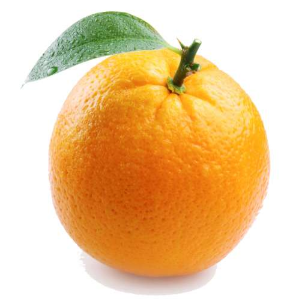


Class:  950
orange: 94.17% | lemon: 2.83% | banana: 0.05% | 

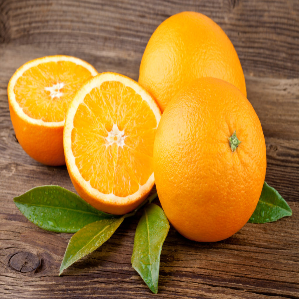


Class:  948
Granny_Smith: 92.66% | spaghetti_squash: 0.15% | banana: 0.11% | 

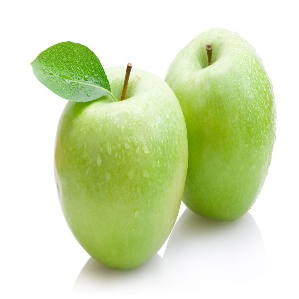


Class:  954
banana: 99.16% | slug: 0.05% | hook: 0.04% | 

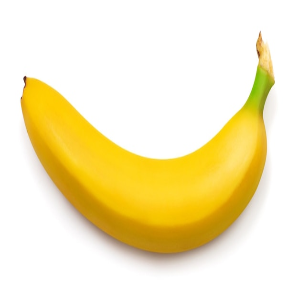


Class:  954
banana: 90.39% | butternut_squash: 0.49% | zucchini: 0.39% | 

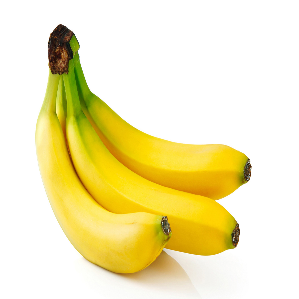

In [16]:
for i in range(5):
  print('Class: ', images_pred[i][0])
  for x in images_pred[i][1][0]:
    print(x[1], round(x[2]*100, 2), end='% | ', sep=': ')
  cv2_imshow(images_fo[i][:,:,::-1]) 
  # [:,:,::-1] для конвертации RGB в BRG, т.к. cv2_imread/imshow использует BGR
  print()

# Задание 2. Использование обученной модели для работы со своим датасетом

## 2.1. Выберите и импортируйте предобученную модель СНС для решения задач классификации из имеющихся в Keras: https://keras.io/api/applications/

In [17]:
model_lr = keras.applications.Xception()

### 2.1.* Своими функциями и методами выполнение Задание 2 (не получится, RAM улетает)

In [ ]:
from zipfile import ZipFile
 
with ZipFile("/content/drive/MyDrive/Colab Notebooks/task_5/t5_dataset.zip", "r") as myzip:
    myzip.extractall(path='t5_dataset')

# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/t5_dataset")))

random.seed(420)
random.shuffle(imagePaths)

In [ ]:
# съело много оперативы
data_mdi = imagePre(imagePaths, from_gdrive=True) # для обучения на вход модели
data_mdo = imagePre(imagePaths, False, from_gdrive=True) # для визуализации
labels_md = []

for imagePath in imagePaths:
  labels_md.append(imagePath.split(os.path.sep)[-2])

In [ ]:
# делим на тренировочные и тестовые
(X_train, X_test, y_train, y_test) = train_test_split(data_mdi, labels_md, test_size=0.25, random_state=42)

# конвертируем метки из целых чисел в векторы 
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(data_mdo[i])
  plt.title(labels_md[i])
  plt.axis("off")

In [ ]:
# first model for first data, separating from scikit learn
my_model_1 = Sequential()
my_model_1.add(base_xception)
my_model_1.add(Flatten())
my_model_1.add(Dense(512, activation='relu'))
my_model_1.add(Dense(5, activation='softmax'))

my_model_1.summary()

In [ ]:
my_model_1.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

## 2.2. Подготовка тренировочных данных. Разделение на обучающую и тестовую выборку

In [27]:
# для себя
import shutil
shutil.rmtree('/content/t5_dataset')

In [28]:
from zipfile import ZipFile
 
with ZipFile("/content/drive/MyDrive/Colab Notebooks/task_2/task2_2/dataset.zip", "r") as myzip:
    myzip.extractall(path='t5_dataset')

In [29]:
# как из лекции, ради интереса // менее затратные вариант по оперативной памяти
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/t5_dataset/dataset',
  validation_split=0.2,
  subset="training",
  seed=420,
  image_size=(71, 71),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/t5_dataset/dataset',
  validation_split=0.2,
  subset="validation",
  seed=420,
  image_size=(71, 71),
  batch_size=32)

class_names_frl = train_ds.class_names
print(class_names_frl)

Found 3186 files belonging to 3 classes.
Using 2549 files for training.
Found 3186 files belonging to 3 classes.
Using 637 files for validation.
['apple', 'banana', 'orange']


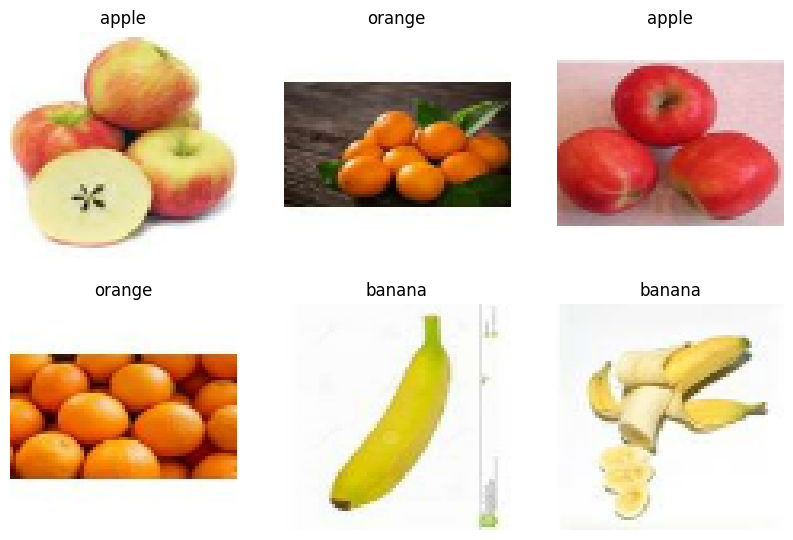

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_frl[labels[i]])
    plt.axis("off")

In [31]:
def process(image, label):
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

In [32]:
# нормализация для вход в модель
train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

## 2.3. Обучение своей модели на основе предобученной модели Xception

In [33]:
base_xception = tf.keras.applications.Xception(
    include_top=False, # убираем полносвязные слои
    input_shape=(71, 71, 3),
    weights="imagenet",
    pooling='avg',
)
base_xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activat

## 2.3. Создаем свою модель на основе Xception

In [34]:
base_xception.trainable = False # замораживаем все слои базовой модели
# Заморозить каждый слой по отдельности
# for layer in base_xception.layers:
    # layer.trainable=False

In [35]:
my_model_1 = Sequential()
my_model_1.add(base_xception)
my_model_1.add(Flatten())
my_model_1.add(Dense(512, activation='relu'))
my_model_1.add(Dense(3, activation='softmax'))

my_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 3)                1539      
 pper)                                                           
                                                                 
Total params: 21,912,107
Trainable params: 1,050,627
Non-trainable params: 20,861,480
____________________________________

In [36]:
my_model_1.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

## 2.4. Визуализация процесса обучения модели

In [37]:
his_1 = my_model_1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
80/80 [==============================] - 7s 45ms/step - loss: 0.3845 - accuracy: 0.8588 - val_loss: 0.1880 - val_accuracy: 0.9278
Epoch 2/10
80/80 [==============================] - 2s 26ms/step - loss: 0.1962 - accuracy: 0.9266 - val_loss: 0.1757 - val_accuracy: 0.9325
Epoch 3/10
80/80 [==============================] - 3s 32ms/step - loss: 0.1218 - accuracy: 0.9596 - val_loss: 0.1911 - val_accuracy: 0.9294
Epoch 4/10
80/80 [==============================] - 2s 30ms/step - loss: 0.1053 - accuracy: 0.9623 - val_loss: 0.1812 - val_accuracy: 0.9435
Epoch 5/10
80/80 [==============================] - 2s 29ms/step - loss: 0.0689 - accuracy: 0.9796 - val_loss: 0.1808 - val_accuracy: 0.9419
Epoch 6/10
80/80 [==============================] - 2s 28ms/step - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.1938 - val_accuracy: 0.9403
Epoch 7/10
80/80 [==============================] - 2s 30ms/step - loss: 0.0441 - accuracy: 0.9867 - val_loss: 0.2197 - val_accuracy: 0.9419
Epoch 8/10
80

## 2.5. Подготовьте набор проверочных данных см. Задание №1 (п. 1.2, 1.3, 1.4)

In [48]:
# Ваш код
images_fi_m1 = imagePre(images, shapes=[71, 71, 3]) # для модели
images_fo_m1 = imagePre(images, False, shapes=[71, 71, 3]) # для визуализации

In [49]:
images_fi_m1[0].shape, images_fo_m1[0].shape

((1, 71, 71, 3), (71, 71, 3))

## 2.6. Организуйте вывод изображений и соответствующих им классов

In [56]:
images_pred_m1 = getListPred(images_fi_m1, my_model_1, fnm=True)

1/1 [==============================] - 0s 70ms/step


In [57]:
images_pred_m1

[[array([[3.3900727e-02, 2.8367499e-09, 9.6609926e-01]], dtype=float32), 2],
 [array([[3.6865927e-04, 2.0313615e-05, 9.9961108e-01]], dtype=float32), 2],
 [array([[1.0000000e+00, 4.2755572e-09, 4.5328258e-10]], dtype=float32), 0],
 [array([[1.6063923e-16, 1.0000000e+00, 1.1761497e-16]], dtype=float32), 1],
 [array([[1.1598465e-17, 1.0000000e+00, 9.6300047e-25]], dtype=float32), 1]]

Class:  orange
apple: 3.39% | banana: 0.0% | orange: 96.61% | 

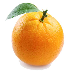


Class:  orange
apple: 0.04% | banana: 0.0% | orange: 99.96% | 

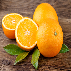


Class:  apple
apple: 100.0% | banana: 0.0% | orange: 0.0% | 

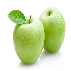


Class:  banana
apple: 0.0% | banana: 100.0% | orange: 0.0% | 

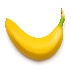


Class:  banana
apple: 0.0% | banana: 100.0% | orange: 0.0% | 

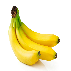

In [67]:
for i in range(5):
  print('Class: ', class_names_frl[images_pred_m1[i][1]])
  for j in range(3):
    print(class_names_frl[j], round(images_pred_m1[i][0][0][j]*100, 2), end='% | ', sep=': ')
  cv2_imshow(images_fo_m1[i][:,:,::-1]) 
  # [:,:,::-1] для конвертации RGB в BRG, т.к. cv2_imread/imshow использует BGR
  print()